In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mcmcrotation import read_file

%matplotlib inline

import celerite
from celerite import terms

from scipy.optimize import minimize
import glob

In [5]:
fns = glob.glob('../data/*.csv')
fn = fns[0]
df = read_file(fn)



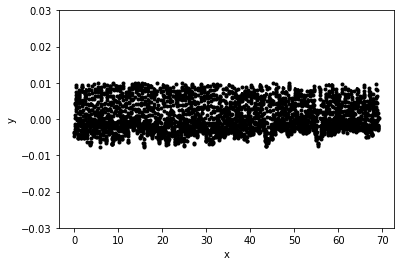

In [31]:
mask = (df.time < 75) & np.abs(df.flux < 0.01) & np.isfinite(df.flux)
t = df.loc[mask, 'time']
y = df.loc[mask, 'flux']
yerr = df.loc[mask, 'ferr'] * 2.

# plt.plot(t, yerr, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
# plt.xlim(0, 10)
plt.ylim(-0.03, 0.03);

In [608]:
# # A non-periodic component
# Q = 1.0 / np.sqrt(2.0)
# w0 = 3.0
# S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15), log_sigma=(-15,0))
# kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
#                        bounds=bounds)
# kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# # A periodic component
# Q = 1.0
# w0 = 3.0
# S0 = np.var(y) / (w0 * Q)
# kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
#                         bounds=bounds)

# A periodic component
Q = 10.
w0 = np.pi/2. 
S0 = 0.02
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)
# kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term


# A jitter term
sigma = 0.001
kernel += terms.JitterTerm(log_sigma=np.log(sigma), bounds=bounds)

In [609]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: 11560.8457945003


In [610]:
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

parameter_dict:
OrderedDict([('kernel:terms[0]:log_S0', -3.912023005428146), ('kernel:terms[0]:log_Q', 2.3025850929940459), ('kernel:terms[0]:log_omega0', 0.45158270528945482), ('kernel:terms[1]:log_sigma', -6.9077552789821368)])

parameter_names:
('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_Q', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_sigma')

parameter_vector:
[-3.91202301  2.30258509  0.45158271 -6.90775528]

parameter_bounds:
[(-15, 15), (-15, 15), (-15, 15), (-15, 0)]



In [611]:


def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -13797.344836407556
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.11095835, -0.02764864,  0.00400178,  0.07748895])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 390
      nit: 39
   status: 0
  success: True
        x: array([-13.03135239,  -7.01491532,   9.45066301,  -9.97165184])


In [612]:
print('period = {}'.format((np.pi * 2) / np.exp(gp.get_parameter_dict()['kernel:terms[0]:log_omega0'])))
print('S0 = {}'.format((np.exp(gp.get_parameter_dict()['kernel:terms[0]:log_S0']))))

period = 0.0004940934208906418
S0 = 2.1905620752794358e-06


In [613]:
x = np.linspace(0, 75, 3000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

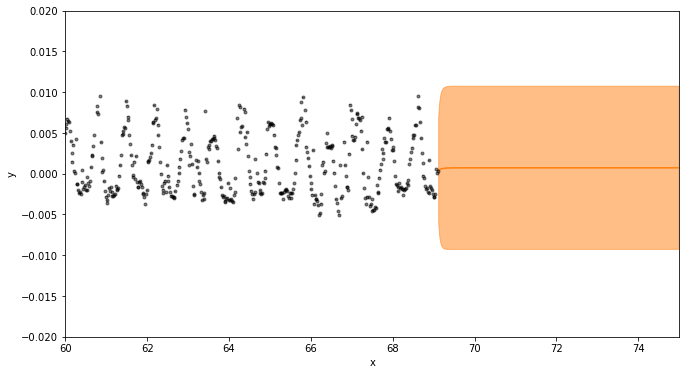

In [614]:
fig, ax = plt.subplots(1,1,figsize=[11,6], )

color = "#ff7f0e"
# plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.5)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+(2*pred_std), pred_mean-(2*pred_std), color=color, alpha=0.5,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(60, 75)
plt.ylim(-0.02, 0.02);

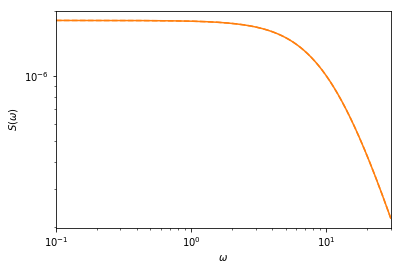

In [572]:
omega = np.exp(np.linspace(np.log(0.1), np.log(30), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

# try something different

In [32]:
# taken from https://github.com/dfm/celerite/blob/master/papers/paper1/figures/rotation.py

# Define the custom kernel
class RotationTerm(terms.Term):
    parameter_names = ("log_amp", "log_timescale", "log_period", "log_factor")

    def get_real_coefficients(self, params):
        log_amp, log_timescale, log_period, log_factor = params
        f = np.exp(log_factor)
        return (
            np.exp(log_amp) * (1.0 + f) / (2.0 + f),
            np.exp(-log_timescale),
        )

    def get_complex_coefficients(self, params):
        log_amp, log_timescale, log_period, log_factor = params
        f = np.exp(log_factor)
        return (
            np.exp(log_amp) / (2.0 + f),
            0.0,
            np.exp(-log_timescale),
            2*np.pi*np.exp(-log_period),
        )

In [33]:
# Set up the GP model
kernel = RotationTerm(
    np.log(np.var(y)), np.log(10), np.log(2.0), np.log(5.0),
    bounds=[
        np.log(np.var(y) * np.array([0.1, 10.0])),
        np.log([np.max(np.diff(t)), (t.max() - t.min())]),
        np.log([3*np.median(np.diff(t)), 0.5*(t.max() - t.min())]),
        [-5.0, 5.0],
    ]
)

In [34]:
gp = celerite.GP(kernel, mean=np.median(y))
gp.compute(t, yerr)
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -42479.55053169416


In [39]:
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)
print(np.e**r.x)



      fun: -13704.361366297551
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -7.27595761e-04,   6.65564585e+01,  -3.27418093e-03,
         0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 25
      nit: 1
   status: 0
  success: True
        x: array([-9.37678743, -1.05746555, -0.25157574,  2.06311922])
[  8.46667640e-05   3.47335000e-01   7.77574561e-01   7.87048133e+00]


In [36]:
x = np.linspace(0, 75, 3000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

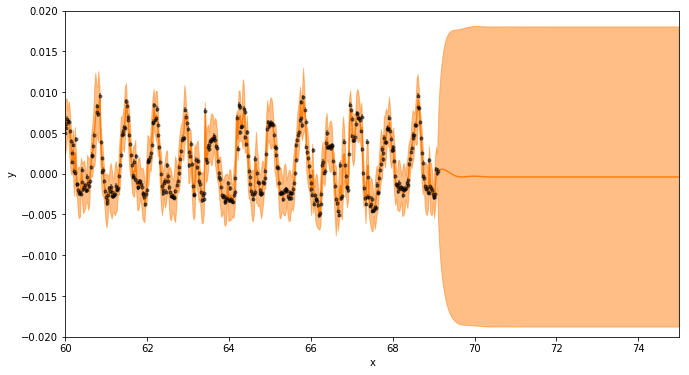

In [37]:
fig, ax = plt.subplots(1,1,figsize=[11,6], )

color = "#ff7f0e"
# plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.5)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+(2*pred_std), pred_mean-(2*pred_std), color=color, alpha=0.5,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(60, 75)
plt.ylim(-0.02, 0.02);

In [44]:
np.std(y)

0.004795872603279047

In [48]:
from scipy.special import erf
erf((1) / (np.sqrt(2) * 1)) + erf((1) / (np.sqrt(2) * 1)) + erf((1) / (np.sqrt(2) * 1)) + erf((1) / (np.sqrt(2) * 1))


2.7307579685483434

In [52]:
erf(1) 

0.84270079294971478